In [1]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None):
  model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

In [3]:
config1024 = load_config("../logs/2021-06-08T10-50-38_radar_vqgan/configs/2021-06-08T10-50-38-project.yaml", display=False)

In [4]:
model1024 = load_vqgan(config1024, ckpt_path="../logs/2021-06-08T10-50-38_radar_vqgan/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [5]:
from skimage import io

In [6]:
img = io.imread('../data/rdhq/Z_RADR_I_Z9010_20190102181800_P_DOR_SA_R_10_230_15.010_clean.png')

In [7]:
img.shape

(256, 256)

In [8]:
from PIL import Image

In [9]:
img = Image.open("../data/rdhq/Z_RADR_I_Z9010_20190102180000_P_DOR_SA_R_10_230_15.010_clean.png")

In [10]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF


In [11]:
def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [12]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


def reconstruct_with_dalle(x, encoder, decoder, do_preprocess=False):
  # takes in tensor (or optionally, a PIL image) and returns a PIL image
  if do_preprocess:
    x = preprocess(x)
  z_logits = encoder(x)
  z = torch.argmax(z_logits, axis=1)
  
  print(f"DALL-E: latent shape: {z.shape}")
  z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

  x_stats = decoder(z).float()
  x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
  x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

  return x_rec


def stack_reconstructions(input, x1, x2, x3, titles=[]):
  assert input.size == x1.size == x2.size == x3.size
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (4*w, h))
  img.paste(input, (0,0))
  img.paste(x1, (1*w,0))
  img.paste(x2, (2*w,0))
  img.paste(x3, (3*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255), font=font) # coordinates, text, color, font
  return img

In [13]:
url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'

In [14]:
x = preprocess(download_image(url), target_image_size=256)

/home/tree/miniconda3/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:364: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [16]:
x.shape

torch.Size([1, 3, 256, 256])

In [18]:
x = x.to(DEVICE)

In [19]:
x2 = reconstruct_with_vqgan(preprocess_vqgan(x), model1024)

VQGAN: latent shape: torch.Size([16, 16])


In [20]:
x2.shape

torch.Size([1, 3, 256, 256])

In [23]:
import matplotlib.pyplot as plt

In [25]:
z, _, [_, _, indices] = model1024.encode(x)

In [26]:
z.shape

torch.Size([1, 256, 16, 16])

In [27]:
img = torch.argmax(z,axis=1)

In [28]:
img.shape

torch.Size([1, 16, 16])

In [31]:
a = img[0].cpu().numpy()

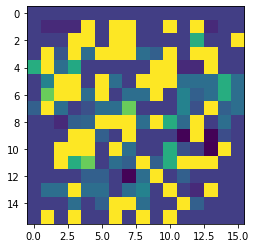

In [33]:
plt.imshow(a)

In [40]:
pic = PIL.Image.open("../data/rdhq/Z_RADR_I_Z9010_20190102175400_P_DOR_SA_R_10_230_15.010_clean.png")

In [43]:
a = pic.convert('RGB')

In [44]:
x = preprocess(a)

In [47]:
x = x.to(DEVICE)

In [51]:
z, _, [_, _, indices] = model1024.encode(x)

In [53]:
z.shape

torch.Size([1, 256, 16, 16])

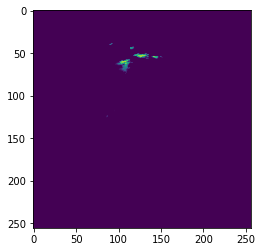

In [46]:
plt.imshow(x.cpu().numpy()[0][0])

In [54]:
img = torch.argmax(z,axis=1)

In [56]:
img.shape

torch.Size([1, 16, 16])

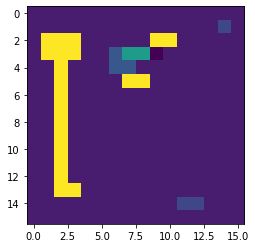

In [57]:
plt.imshow(img[0].cpu().numpy())

In [59]:
img[0]

tensor([[ 61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,
          61,  61],
        [ 61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,
          88,  61],
        [ 61, 244, 244, 244,  61,  61,  61,  61,  61, 244, 244,  61,  61,  61,
          61,  61],
        [ 61, 244, 244, 244,  61,  61, 100, 155, 155,  46,  61,  61,  61,  61,
          61,  61],
        [ 61,  61, 244,  61,  61,  61, 100, 100,  61,  61,  61,  61,  61,  61,
          61,  61],
        [ 61,  61, 244,  61,  61,  61,  61, 244, 244,  61,  61,  61,  61,  61,
          61,  61],
        [ 61,  61, 244,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,
          61,  61],
        [ 61,  61, 244,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,
          61,  61],
        [ 61,  61, 244,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,
          61,  61],
        [ 61,  61, 244,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,
          61,  61],
        [ 